In [1]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')
%qtconsole

In [2]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [3]:
# Load csv into df
df = pd.read_csv(data_interim_dir + 'merged_data.csv',parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Remove basin rig counts
df = df.iloc[:,5:]

# Filter values for only past months
df = df[df.index < this_month]
df = df.reset_index()
df.head()

,date,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
0,2020-08-28,180.0,33.096,39.220,42.932,45.258,43.074,43.374,43.688,44.000,...,28.811321,31.547123,7.593252,62.988280,39.220,43.811816,39.220,52.536276,39.220,96.348093
1,2020-08-21,183.0,26.398,38.350,42.726,44.792,42.726,42.968,43.266,43.570,...,28.813293,31.543548,7.582903,62.921314,38.350,43.572078,38.350,52.246733,38.350,95.818811
2,2020-08-14,172.0,23.464,37.872,42.076,44.538,42.094,42.364,42.692,42.996,...,28.815265,31.539973,7.572554,62.854347,37.872,43.332339,37.872,51.957190,37.872,95.289529
3,2020-08-07,176.0,15.712,37.322,41.568,44.356,41.614,41.868,42.214,42.514,...,28.817237,31.536398,7.562205,62.787381,37.322,43.092600,37.322,51.667647,37.322,94.760247
4,2020-07-31,180.0,3.324,34.185,40.686,43.224,40.820,41.086,41.368,41.620,...,28.786449,31.532662,7.583468,62.703200,34.185,42.866169,34.185,51.407257,34.185,94.273426


In [4]:
df.describe()

,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,usa_net_import_smooth,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,930.600000,70.500197,70.037340,69.180553,76.755011,69.232256,69.578187,69.809704,69.960257,6.751362,...,35.266772,32.298248,2.252154,60.369373,70.037340,46.353795,70.037340,48.878156,70.037340,95.231951
std,387.143193,23.644141,23.834185,23.993532,28.605105,23.929407,23.550224,23.236729,22.963296,1.748627,...,1.792355,0.787375,1.304765,3.720457,23.834185,1.848984,23.834185,3.373133,23.834185,4.368257
min,172.000000,3.324000,3.324000,3.324000,14.236000,3.920000,19.070000,22.670000,24.834000,1.997500,...,27.249729,29.738710,0.798167,54.123720,3.324000,35.169788,3.324000,41.998207,3.324000,81.081620
25%,670.000000,50.542000,50.227500,49.151500,52.686000,49.298500,49.813000,50.695000,50.977500,6.070375,...,34.517828,31.738004,1.635733,57.362719,50.227500,45.885470,50.227500,46.118646,50.227500,91.876330
50%,843.500000,64.104000,62.987000,61.598000,67.870000,61.587000,61.460000,61.421000,61.339000,7.214875,...,35.366460,32.314263,2.029850,60.858994,62.987000,46.578796,62.987000,49.194502,62.987000,95.204843
75%,1357.000000,93.973625,93.973625,93.973625,108.427500,94.007000,94.146000,94.582500,94.676500,7.797437,...,36.517047,32.768237,2.467728,62.387381,93.973625,47.416907,93.973625,51.655833,93.973625,99.184324
max,1609.000000,112.296000,112.296000,112.296000,126.624000,112.808000,113.302000,113.578000,113.692000,9.474250,...,37.737702,33.946000,9.080444,67.705728,112.296000,48.904341,112.296000,54.729117,112.296000,102.590146


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   500 non-null    datetime64[ns]
 1   Total US RigCount      500 non-null    float64       
 2   wti_spot_lag_14        500 non-null    float64       
 3   wti_spot_lag_9         500 non-null    float64       
 4   wti_spot               500 non-null    float64       
 5   brent_spot             500 non-null    float64       
 6   wti_fut_1              500 non-null    float64       
 7   wti_fut_2              500 non-null    float64       
 8   wti_fut_3              500 non-null    float64       
 9   wti_fut_4              500 non-null    float64       
 10  usa_net_import_smooth  500 non-null    float64       
 11  usa_net_import         500 non-null    float64       
 12  usa_stocks_all         500 non-null    float64       
 13  usa_s

Looks good! Let's get started.

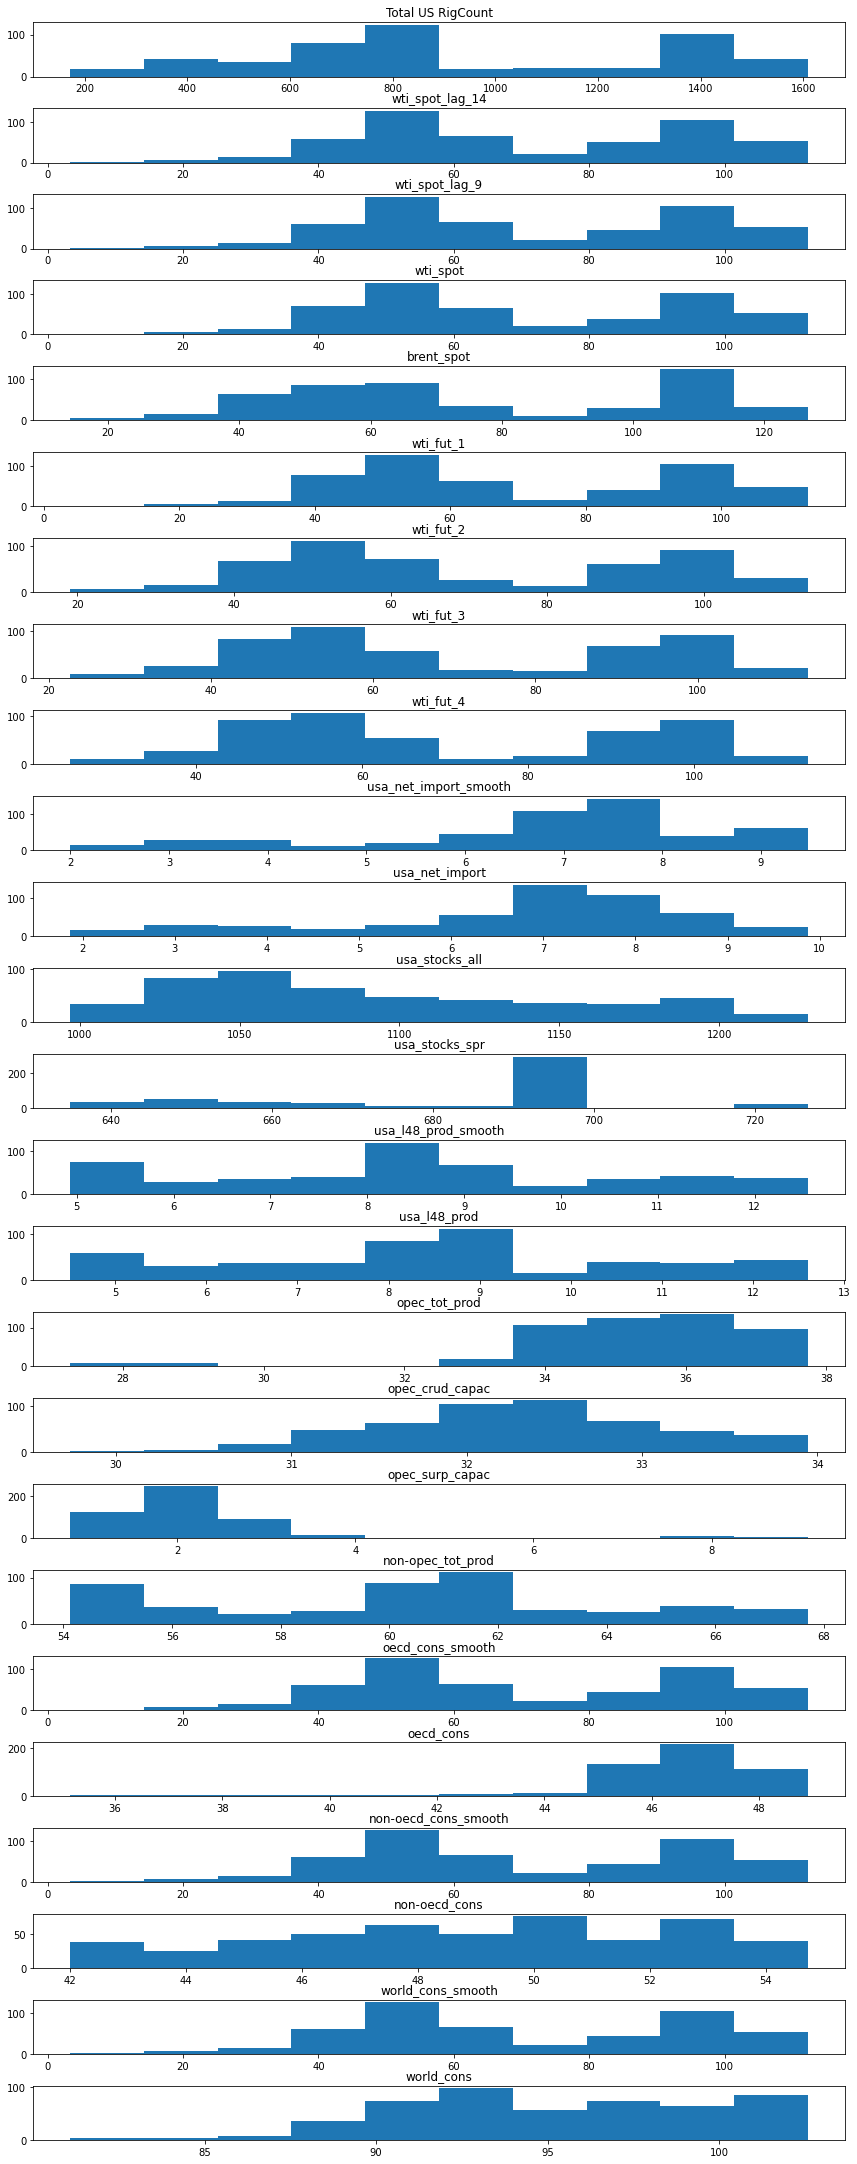

In [6]:
fig, ax = plt.subplots(len(df.columns)-1,figsize=(12,30))
fig.tight_layout()
for i in range(1,len(df.columns)):
    ax[i-1].hist(df.iloc[:,i])
    ax[i-1].set(title=df.columns[i])

Values between the features are very inconsistent and as such should be scaled to minimize any weighting issues with number sizes.

## Start TSFresh feature extraction

In [7]:
from tsfresh import extract_relevant_features

In [8]:
date = df.iloc[:,0]
X = df.iloc[:,2:]
y = df.iloc[:,1]

X = pd.concat([date,X],axis=1)
X.info()
X = X.reset_index()
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   500 non-null    datetime64[ns]
 1   wti_spot_lag_14        500 non-null    float64       
 2   wti_spot_lag_9         500 non-null    float64       
 3   wti_spot               500 non-null    float64       
 4   brent_spot             500 non-null    float64       
 5   wti_fut_1              500 non-null    float64       
 6   wti_fut_2              500 non-null    float64       
 7   wti_fut_3              500 non-null    float64       
 8   wti_fut_4              500 non-null    float64       
 9   usa_net_import_smooth  500 non-null    float64       
 10  usa_net_import         500 non-null    float64       
 11  usa_stocks_all         500 non-null    float64       
 12  usa_stocks_spr         500 non-null    float64       
 13  usa_l

,index,date,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
0,0,2020-08-28,33.096,39.220,42.932,45.258,43.074,43.374,43.688,44.000,...,28.811321,31.547123,7.593252,62.988280,39.220,43.811816,39.220,52.536276,39.220,96.348093
1,1,2020-08-21,26.398,38.350,42.726,44.792,42.726,42.968,43.266,43.570,...,28.813293,31.543548,7.582903,62.921314,38.350,43.572078,38.350,52.246733,38.350,95.818811
2,2,2020-08-14,23.464,37.872,42.076,44.538,42.094,42.364,42.692,42.996,...,28.815265,31.539973,7.572554,62.854347,37.872,43.332339,37.872,51.957190,37.872,95.289529
3,3,2020-08-07,15.712,37.322,41.568,44.356,41.614,41.868,42.214,42.514,...,28.817237,31.536398,7.562205,62.787381,37.322,43.092600,37.322,51.667647,37.322,94.760247
4,4,2020-07-31,3.324,34.185,40.686,43.224,40.820,41.086,41.368,41.620,...,28.786449,31.532662,7.583468,62.703200,34.185,42.866169,34.185,51.407257,34.185,94.273426


In [9]:
extracted_features = extract_relevant_features(X,y, column_id='index',column_sort='date')

Feature Extraction: 100%|██████████████████████| 10/10 [05:08<00:00, 30.84s/it]


In [10]:
extracted_features.info()

df_feat = pd.concat([df,extracted_features],axis=1)
df_feat.info()
df_feat.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Columns: 499 entries, wti_spot_lag_14__sum_values to usa_stocks_spr__benford_correlation
dtypes: float64(499)
memory usage: 1.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 525 entries, date to usa_stocks_spr__benford_correlation
dtypes: datetime64[ns](1), float64(524)
memory usage: 2.0 MB


,date,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,...,opec_surp_capac__quantile__q_0.3,opec_surp_capac__quantile__q_0.1,opec_surp_capac__minimum,opec_surp_capac__maximum,opec_surp_capac__mean,opec_surp_capac__median,opec_surp_capac__abs_energy,opec_surp_capac__sum_values,opec_surp_capac__quantile__q_0.2,usa_stocks_spr__benford_correlation
0,2020-08-28,180.0,33.096,39.220,42.932,45.258,43.074,43.374,43.688,44.000,...,7.593252,7.593252,7.593252,7.593252,7.593252,7.593252,57.657479,7.593252,7.593252,-0.200946
1,2020-08-21,183.0,26.398,38.350,42.726,44.792,42.726,42.968,43.266,43.570,...,7.582903,7.582903,7.582903,7.582903,7.582903,7.582903,57.500418,7.582903,7.582903,-0.200946
2,2020-08-14,172.0,23.464,37.872,42.076,44.538,42.094,42.364,42.692,42.996,...,7.572554,7.572554,7.572554,7.572554,7.572554,7.572554,57.343572,7.572554,7.572554,-0.200946
3,2020-08-07,176.0,15.712,37.322,41.568,44.356,41.614,41.868,42.214,42.514,...,7.562205,7.562205,7.562205,7.562205,7.562205,7.562205,57.186940,7.562205,7.562205,-0.200946
4,2020-07-31,180.0,3.324,34.185,40.686,43.224,40.820,41.086,41.368,41.620,...,7.583468,7.583468,7.583468,7.583468,7.583468,7.583468,57.508993,7.583468,7.583468,-0.200946


## Scaler

In [11]:
scaler = MinMaxScaler()

df_scaled = df_feat.copy()

for col in df.columns[2:]:
    scaler.fit(df[[col]])
    df_scaled[col] = scaler.transform(df[[col]])
    
df_scaled.describe()

,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,usa_net_import_smooth,...,opec_surp_capac__quantile__q_0.3,opec_surp_capac__quantile__q_0.1,opec_surp_capac__minimum,opec_surp_capac__maximum,opec_surp_capac__mean,opec_surp_capac__median,opec_surp_capac__abs_energy,opec_surp_capac__sum_values,opec_surp_capac__quantile__q_0.2,usa_stocks_spr__benford_correlation
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,930.600000,0.616454,0.612206,0.604344,0.556278,0.599811,0.535998,0.518543,0.507847,0.635819,...,2.252154,2.252154,2.252154,2.252154,2.252154,2.252154,6.771203,2.252154,2.252154,-0.203390
std,387.143193,0.216974,0.218718,0.220181,0.254521,0.219762,0.249917,0.255607,0.258427,0.233875,...,1.304765,1.304765,1.304765,1.304765,1.304765,1.304765,12.092390,1.304765,1.304765,0.009686
min,172.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.798167,0.798167,0.798167,0.798167,0.798167,0.798167,0.637070,0.798167,0.798167,-0.241690
25%,670.000000,0.433304,0.430418,0.420544,0.342118,0.416745,0.326248,0.308279,0.294217,0.544739,...,1.635733,1.635733,1.635733,1.635733,1.635733,1.635733,2.675651,1.635733,1.635733,-0.200946
50%,843.500000,0.557758,0.547508,0.534761,0.477222,0.529599,0.449847,0.426266,0.410824,0.697813,...,2.029850,2.029850,2.029850,2.029850,2.029850,2.029850,4.120299,2.029850,2.029850,-0.200946
75%,1357.000000,0.831862,0.831862,0.831862,0.838092,0.827336,0.796714,0.791047,0.786001,0.775730,...,2.467728,2.467728,2.467728,2.467728,2.467728,2.467728,6.089706,2.467728,2.467728,-0.200946
max,1609.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,9.080444,9.080444,9.080444,9.080444,9.080444,9.080444,82.454461,9.080444,9.080444,-0.200946


## Train / Test Split
Define features X, and target variable y

In [12]:
X = df_scaled.iloc[:,2:]
y = df_scaled.iloc[:,1]

Train / test split will be done using sklearn's TimeSeriesSplit. Will need to be redefined and used in a pipeline in the modelling phase.

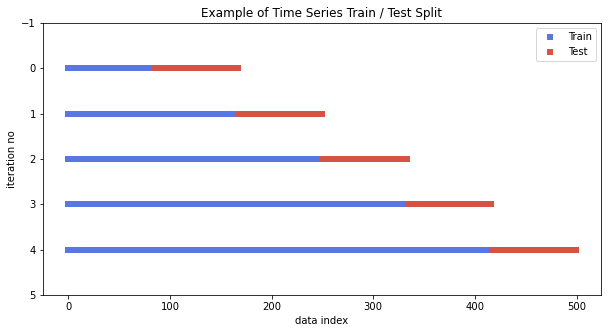

In [13]:
n_splits = 5

ts_cv = TimeSeriesSplit(n_splits = n_splits)

X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()

fig, ax = plt.subplots(figsize=(10,5))
for ii, (tr,tt) in enumerate(ts_cv.split(X,y)):
    train = ax.scatter(tr,[ii]*len(tr), c=[plt.cm.coolwarm(.1)],marker='_',lw=6,label='Train')
    test = ax.scatter(tt,[ii]*len(tt), c=[plt.cm.coolwarm(.9)],marker='_',lw=6,label='Test')
    
    ax.set(ylim=[5,-1], title='Example of Time Series Train / Test Split',xlabel='data index',ylabel='iteration no')
    ax.legend([train,test],['Train','Test'])

In [14]:
# Save preprocessed file as CSV
df_feat.to_csv(data_processed_dir+'processed_data.csv',index=False)